In [1]:
# RNA-Seq Data Analysis. Task: Analyze a provided RNA-Seq dataset and perform 
# differential gene expression analysis. 
import pandas as pd
df=pd.read_csv('rna_seq_counts_large.csv')
df

,Unnamed: 0,Sample1,Sample2,Sample3,Sample4
0,Gene1,96,98,108,119
1,Gene2,107,109,129,125
2,Gene3,88,122,107,137
3,Gene4,103,103,124,125
4,Gene5,111,99,120,117
...,...,...,...,...,...
95,Gene96,93,83,117,101
96,Gene97,115,91,135,104
97,Gene98,109,113,127,136
98,Gene99,102,132,116,155


Using separator: ',' to read rna_seq_counts_large.csv
Detected columns: ['Gene', 'Sample1', 'Sample2', 'Sample3', 'Sample4']
Sample columns used: ['Sample1', 'Sample2', 'Sample3', 'Sample4'] 
Specified control/treatment column names not found in file - doing automatic split.
Auto-selected control columns: ['Sample1', 'Sample2']
Auto-selected treatment columns: ['Sample3', 'Sample4']


C:\Users\kakad\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\kakad\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\kakad\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\kakad\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurre

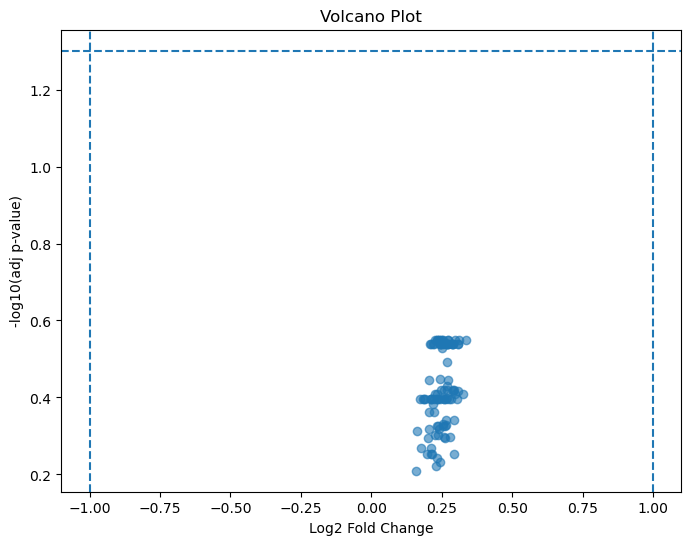

Results saved: DEGs_all_results.csv and DEGs_significant.csv
Top hits (by adj_pval):
Empty DataFrame
Columns: [Gene, log2FC, adj_pval]
Index: []


In [3]:
# It takes RNA-Seq gene count data
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

filename = "rna_seq_counts_large.csv"   

# 1) Try to detect delimiter and read file
with open(filename, 'r', newline='') as fh:
    sample = fh.read(4096)
try:
    dialect = csv.Sniffer().sniff(sample)
# Uses csv.Sniffer() to automatically detect which separator is used —
# e.g., ,, ;, \t (tab), or |.
    sep = dialect.delimiter
except Exception:
    sep = ','   
print(f"Using separator: '{sep}' to read {filename}")

df = pd.read_csv(filename, sep=sep)

df.columns = df.columns.str.strip() #Removes extra spaces from column names,

# If first column is not named 'Gene', rename it 
if 'Gene' not in df.columns:
    df.rename(columns={df.columns[0]: 'Gene'}, inplace=True)

#  2) Identify sample columns and convert to numeric 
sample_cols = [c for c in df.columns if c != 'Gene']
if len(sample_cols) < 2:
    raise ValueError("No numeric sample columns detected. Check the file and column names.")

# convert sample columns to numeric (coerce errors to NaN then fill with 0)
df[sample_cols] = df[sample_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

print("Detected columns:", df.columns.tolist())
print("Sample columns used:", sample_cols[:10], "..." if len(sample_cols)>10 else "")

control_cols = ["Control_1", "Control_2"]
treatment_cols = ["Treatment_1", "Treatment_2"]

# If the specified columns are not present, auto-split the sample columns
if not (set(control_cols).issubset(df.columns) and set(treatment_cols).issubset(df.columns)):
    print("Specified control/treatment column names not found in file - doing automatic split.")
    half = len(sample_cols) // 2
    control_cols = sample_cols[:half]
    treatment_cols = sample_cols[half:]
    print("Auto-selected control columns:", control_cols)
    print("Auto-selected treatment columns:", treatment_cols)

if len(control_cols) < 1 or len(treatment_cols) < 1:
    raise ValueError("Could not determine control/treatment columns. Edit control_cols/treatment_cols manually.")

df['Control_mean'] = df[control_cols].mean(axis=1)
df['Treatment_mean'] = df[treatment_cols].mean(axis=1)
df['log2FC'] = np.log2((df['Treatment_mean'] + 1) / (df['Control_mean'] + 1))
# Calculates log2 fold change for each gene.
# +1 prevents division by zero.
# log2FC > 0 → upregulated in treatment.
#log2FC < 0 → downregulated in treatment.

p_values = []
for idx, row in df.iterrows():
    control_vals = row[control_cols].values.astype(float)
    treat_vals = row[treatment_cols].values.astype(float)

    if np.all(np.isnan(control_vals)) or np.all(np.isnan(treat_vals)):
        p = 1.0
    else:
        try:
            _, p = ttest_ind(control_vals, treat_vals, equal_var=False, nan_policy='omit')
            if np.isnan(p):
                p = 1.0
        except Exception:
            p = 1.0
    p_values.append(p)

df['p_value'] = p_values

df['adj_pval'] = multipletests(df['p_value'], method='fdr_bh')[1]

# replace 0 with a tiny value for plotting
df['adj_pval_plot'] = df['adj_pval'].replace(0, 1e-300)

deg = df[(df['adj_pval'] < 0.05) & (df['log2FC'].abs() > 1)]

plt.figure(figsize=(8,6))
plt.scatter(df['log2FC'], -np.log10(df['adj_pval_plot']), alpha=0.6)
if not deg.empty:
    plt.scatter(deg['log2FC'], -np.log10(deg['adj_pval_plot'].loc[deg.index]), alpha=0.9)
plt.axhline(-np.log10(0.05), linestyle='--')
plt.axvline(1, linestyle='--')
plt.axvline(-1, linestyle='--')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(adj p-value)')
plt.title('Volcano Plot')
plt.show()

#  8) Save results 
df.to_csv("DEGs_all_results.csv", index=False)
deg[['Gene','log2FC','p_value','adj_pval']].to_csv("DEGs_significant.csv", index=False)

print("Results saved: DEGs_all_results.csv and DEGs_significant.csv")
print("Top hits (by adj_pval):")
print(deg[['Gene','log2FC','adj_pval']].sort_values('adj_pval').head(20))
